In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import csv
import sys 

%load_ext autoreload
%autoreload 2
import os
sys.path.append("../src")
import helpers, preprocessing, exploration, polynomial_exp
from helpers import split_data_rand
from helpers import build_model_data
from json_parser import parse_json_file
import fitters
import metrics
from preprocessing import clean_data
from preprocessing import resample, prepare_data
from colors import style

In [91]:
# Read and Load Data
seed = 499912
degree = 1

x_df = pd.read_csv("../data/raw/x_train.csv")
y_df = pd.read_csv("../data/raw/y_train.csv")

x = x_df.values
y = y_df["_MICHD"].values

l = [(1, 1), (0.1, 1), (0.2, 1), (0.165, 1)]

# Prepare data for fittings and parameters:
for (d,u) in l :

    ratio = 0.69
    # downsampling_size = 0.1808
    downsampling_size = d
    #upsamplingsize = 1.04
    upsamplingsize = u
    y_train, x_train, y_test, x_test = prepare_data(x, y, seed, ratio, downsampling_size, upsamplingsize)

    print("----------------------------------------------------------------------------")
    print("GD")
    gm = fitters.GradientFitter(y_train, x_train, y_test, x_test, 1000, 0.01)
    w, loss = gm.fit()
    metrics.agg_results_and_print_results(gm, y_test, x_test, w)
    print("----------------------------------------------------------------------------")
    print("SGD")
    sgm = fitters.StochasticGradientFitter(y_train, x_train, y_test, x_test, 10000, 0.001)
    w, loss = sgm.fit()
    metrics.agg_results_and_print_results(sgm, y_test, x_test, w)
    print("----------------------------------------------------------------------------")
    print("LSQ")
    lsq = fitters.LeastSquareFitter(y_train, x_train, y_test, x_test)
    w, loss = lsq.fit()
    metrics.agg_results_and_print_results(lsq, y_test, x_test, w)
    print("----------------------------------------------------------------------------")
    print("RRF")
    rrf = fitters.RidgeRegressionFitter(y_train, x_train, y_test, x_test, 10e-7, 0.151)
    w, loss = rrf.fit()
    metrics.agg_results_and_print_results(rrf, y_test, x_test, w)
    print("----------------------------------------------------------------------------")
    print("LRF")
    y_train[np.where(y_train == -1)] = 0
    lg = fitters.LogisticRegressionFitter(y_train, x_train, y_test, x_test, 1000, 0.005)
    w, loss = lg.fit()
    metrics.agg_results_and_print_results(lg, y_test, x_test, w)
    print("----------------------------------------------------------------------------")
    print("RLR")
    y_train[np.where(y_train == -1)] = 0
    rlg = fitters.RegLogisticRegressionFitter(y_train, x_train, y_test, x_test, 1000, 0.005, 10e-4)
    w, loss = rlg.fit()
    metrics.agg_results_and_print_results(rlg, y_test, x_test, w)
print("----------------------------------------------------------------------------")

----------------------------------------------------------------------------
GD
Test accuracy: 0.8891
F1-Score: 0.2518
----------------------------------------------------------------------------
SGD
Test accuracy: 0.8891
F1-Score: 0.2518
----------------------------------------------------------------------------
LSQ
Test accuracy: 0.9148
F1-Score: 0.0995
----------------------------------------------------------------------------
RRF
Test accuracy: 0.9137
F1-Score: 0.0398
----------------------------------------------------------------------------
LRF
Test accuracy: 0.9133
F1-Score: 0.0417
----------------------------------------------------------------------------
RLR
Test accuracy: 0.9133
F1-Score: 0.0411
----------------------------------------------------------------------------
GD
Test accuracy: 0.6973
F1-Score: 0.3146
----------------------------------------------------------------------------
SGD
Test accuracy: 0.6973
F1-Score: 0.3146
------------------------------------------

In [7]:
import helpers
helpers.make_submission(rrf, w, "testMTN.csv")

In [8]:
import cross_validation as cv
import costs

# Cross-validate threshold for all models, 
tresholds = np.linspace(-0.2, 0.2, 5)
cvv = cv.CValidator(y, x, 4, tresholds, "lrgd", costs.compute_mse, "f1")
cvv = cv.CValidator(y, x, 4, tresholds, "lrsgd", costs.compute_mse, "f1")
cvv = cv.CValidator(y, x, 4, tresholds, "lsq", costs.compute_rmse, "f1")
cvv = cv.CValidator(y, x, 4, tresholds, "rrf", costs.compute_rmse, "f1")
cvv = cv.CValidator(y, x, 4, tresholds, "lr", costs.compute_log_loss, "f1")
cvv = cv.CValidator(y, x, 4, tresholds, "rlr", costs.compute_log_loss, "f1")

# Cross validates gamma for lrgd, lrsgd, lr, rlr

# Cross validates lambda for rrf, rlr

In [9]:

cvv.cross_validates()

(0.01, 0.3490467484983024)

In [86]:

y = y_df["_MICHD"].values
def scale(factor): 
    a = len(np.where(y == 1)[0])
    b = len(np.where(y == -1)[0])
    b = factor * b
    print(f"% of 1 : {100 * a / (a + b):.2f}%")
    print(f"% of -1 : {100 * b / (b + a):.2f}%")
    print(a,b)
    
scale(0.1) ## Balanced
scale(0.2) ## third 
scale(0.16512820512820514)

% of 1 : 49.20%
% of -1 : 50.80%
28975 29916.0
% of 1 : 32.63%
% of -1 : 67.37%
28975 59832.0
% of 1 : 36.97%
% of -1 : 63.03%
28975 49399.75384615385


In [76]:
# Read and Load Data
seed = 499912
degree = 1

x_df = pd.read_csv("../data/raw/x_train.csv")
y_df = pd.read_csv("../data/raw/y_train.csv")

x = x_df.values
y = y_df["_MICHD"].values

d = np.linspace(0.12, 0.20, 40)
rec = {}
ratio = 0.69
# Prepare data for fittings and parameters:
for s in d:
        # downsampling_size = 0.1808
        downsampling_size = s
        #upsamplingsize = 1.04
        upsamplingsize = 1.04
        y_train, x_train, y_test, x_test = prepare_data(x, y, seed, ratio, downsampling_size, upsamplingsize)
        print("----------------------------------------------------------------------------")
        print("RRF, downsampling factor:" + str(s))
        rrf = fitters.RidgeRegressionFitter(y_train, x_train, y_test, x_test, 10e-7, 0.151)
        w, loss = rrf.fit()
        # metrics.agg_results_and_print_results(rrf, y_test, x_test, w)
        # Print in standard output
        test_preds = rrf.predict(x_test, w)
        test_preds[np.where(test_preds == 0)] = -1 # In case of logistic regression
        testing_accuracy = metrics.compute_accuracy(y_test, test_preds)
        f1score = metrics.f1_score(y_test, test_preds)
        rec[s] = f1score
        # print(style.BOLD + style.GREEN  + f"Test accuracy: {testing_accuracy:.4f}" + style.RESET)
        # print(style.BOLD + style.YELLOW + f"F1-Score: {f1score:.4f}" + style.RESET )
        print("----------------------------------------------------------------------------")
        
k = min(rec, key=rec.get)
print(k)
print(rec[k])

----------------------------------------------------------------------------
RRF, downsampling factor:0.12
----------------------------------------------------------------------------
----------------------------------------------------------------------------
RRF, downsampling factor:0.12205128205128205
----------------------------------------------------------------------------
----------------------------------------------------------------------------
RRF, downsampling factor:0.1241025641025641
----------------------------------------------------------------------------
----------------------------------------------------------------------------
RRF, downsampling factor:0.12615384615384614
----------------------------------------------------------------------------
----------------------------------------------------------------------------
RRF, downsampling factor:0.1282051282051282
----------------------------------------------------------------------------
----------------------

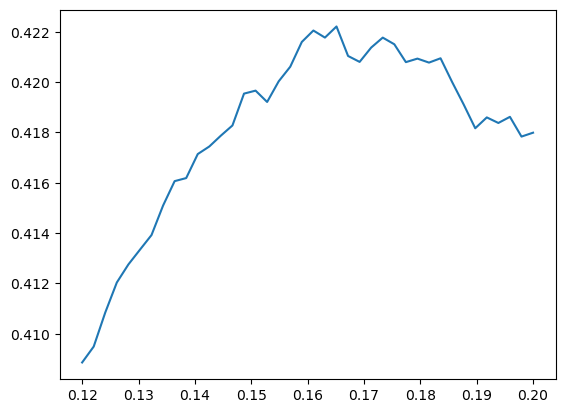

In [77]:
import matplotlib.pylab as plt

lists = sorted(rec.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

In [78]:
print(rec)

{0.12: 0.40885929750662414, 0.12205128205128205: 0.4094916655186665, 0.1241025641025641: 0.41084542828303927, 0.12615384615384614: 0.4120376880888764, 0.1282051282051282: 0.41275477593920884, 0.13025641025641024: 0.41334097585441, 0.1323076923076923: 0.4139228598306679, 0.13435897435897437: 0.41509433962264153, 0.13641025641025642: 0.4160653806508614, 0.13846153846153847: 0.41618711713384077, 0.14051282051282052: 0.4171411447407852, 0.14256410256410257: 0.4174426527367704, 0.14461538461538462: 0.41787393448262683, 0.14666666666666667: 0.4182774083810113, 0.14871794871794872: 0.4195427008012507, 0.15076923076923077: 0.41966152510947174, 0.15282051282051282: 0.419210840972499, 0.15487179487179487: 0.4200313997021054, 0.15692307692307694: 0.4206120209696428, 0.15897435897435896: 0.42159635961136394, 0.16102564102564104: 0.4220502421056988, 0.1630769230769231: 0.42176927574972845, 0.16512820512820514: 0.42221097900328863, 0.1671794871794872: 0.4210391604811876, 0.16923076923076924: 0.42080

In [10]:
# Read and Load Data
seed = 499912
degree = 1

x_df = pd.read_csv("../data/raw/x_train.csv")
y_df = pd.read_csv("../data/raw/y_train.csv")

rec = {}
ratio = 0.69
x = x_df.values
y = y_df["_MICHD"].values
# Prepare data for fittings and parameters:
# downsampling_size = 0.1808
downsampling_size = 0.16512820512820514
#upsamplingsize = 1.04
upsamplingsize = 1
print(x.shape)
print(y.shape)
y_train, x_train, y_test, x_test = prepare_data(x, y, seed, 0.69, downsampling_size, upsamplingsize)
print("----------------------------------------------------------------------------")
print("RRF, downsampling factor:" + str(downsampling_size))
print(x_train.shape)
print(x_test.shape)
rrf = fitters.RidgeRegressionFitter(y_train, x_train, y_test, x_test, 10e-7, 0.151)
w, loss = rrf.fit()
# metrics.agg_results_and_print_results(rrf, y_test, x_test, w)
# Print in standard output
test_preds = rrf.predict(x_test, w)
test_preds[np.where(test_preds == 0)] = -1 # In case of logistic regression
testing_accuracy = metrics.compute_accuracy(y_test, test_preds)
f1score = metrics.f1_score(y_test, test_preds)
# rec["0"] = f1score
print(f1score)
# helpers.make_submission(rrf, w, "test-ult.csv")
# print(style.BOLD + style.GREEN  + f"Test accuracy: {testing_accuracy:.4f}" + style.RESET)
# print(style.BOLD + style.YELLOW + f"F1-Score: {f1score:.4f}" + style.RESET )
print("----------------------------------------------------------------------------")

(328135, 322)
(328135,)
(54153, 322)
(101722, 322)
(54153, 322)
(54153, 322)
[27, 31, 33, 254, 34, 40, 43, 44, 45, 47, 48, 49, 51, 53, 28, 29, 61, 67, 70, 233, 235, 238, 243, 247, 260, 263, 265, 279, 280, 288, 289, 298, 262, 266, 290, 261, 73, 74, 75, 77, 88, 109, 137, 59, 232, 249, 60, 39, 66, 104, 58, 316, 38, 1, 24, 30, 32, 35, 36, 37, 63, 64, 68, 69, 78, 79]
new_data : (54153, 196)
(101722, 322)
(101722, 322)
[27, 31, 33, 254, 34, 40, 43, 44, 45, 47, 48, 49, 51, 53, 28, 29, 61, 67, 70, 233, 235, 238, 243, 247, 260, 263, 265, 279, 280, 288, 289, 298, 262, 266, 290, 261, 73, 74, 75, 77, 88, 109, 137, 59, 232, 249, 60, 39, 66, 104, 58, 316, 38, 1, 24, 30, 32, 35, 36, 37, 63, 64, 68, 69, 78, 79]
new_data : (101722, 196)
----------------------------------------------------------------------------
RRF, downsampling factor:0.16512820512820514
(54153, 196)
(101722, 196)
0.4224592167938288
----------------------------------------------------------------------------


In [8]:
# Read and Load Data
seed = 499912
degree = 1

x_df = pd.read_csv("../data/raw/x_train.csv")
y_df = pd.read_csv("../data/raw/y_train.csv")

x = x_df.values
y = y_df["_MICHD"].values
rec = {}
ratio = 0.69

l = [(1, 1), (0.1, 1), (0.2, 1), (0.165, 1)]

# Prepare data for fittings and parameters:
for (d,u) in l: 
    ratio = 0.69
    # downsampling_size = 0.1808
    downsampling_size = d
    #upsamplingsize = 1.04
    upsamplingsize = u
    y_train, x_train, y_test, x_test = prepare_data(x, y, seed, ratio, downsampling_size, upsamplingsize)

    print("----------------------------------------------------------------------------")
    print("SGD")
    sgm = fitters.StochasticGradientFitter(y_train, x_train, y_test, x_test, 10000, 0.001)
    w, loss = sgm.fit()
    metrics.agg_results_and_print_results(sgm, y_test, x_test, w)
    print("----------------------------------------------------------------------------")


print("----------------------------------------------------------------------------")

KeyboardInterrupt: 

In [6]:
import cross_validation as cv
import costs
tresholds = np.linspace(-0.2, 0.2, 5)
x_df = pd.read_csv("../data/raw/x_train.csv")
y_df = pd.read_csv("../data/raw/y_train.csv")


In [7]:

x = x_df.values
y = y_df["_MICHD"].values
cvv = cv.CValidator(y, x, 4, tresholds, "rrf", costs.compute_mse, "thresh")

In [12]:
ratio = 0.69
seed = 499912
cvv.cross_validates(ratio, seed, 0.165)

ValueError: shapes (101722,1585) and (1444,) not aligned: 1585 (dim 1) != 1444 (dim 0)